In [1]:
import analyticslib 
from analyticslib import DataSet


# Load Data

In [2]:
# get all rows
dataMain = DataSet(spark_context=sc, filename="clinvar_conflicting.csv", sampling_mode="ALL")


loading COS csv


In [3]:
dataMain.compute_stats()

# Data Cleansing

 

In [4]:
dataMain.dataset.createOrReplaceTempView("tmp_dataset")

In [5]:
total_rows = dataMain.dataset.count()

In [6]:
# Analyze missing BLOSUM62
blossom62_rows = spark.sql("select count (*) as cnt from tmp_dataset where BLOSUM62 is not null").head()[0]

In [7]:
blossom62_with_missense_rows = spark.sql("select count (*) as cnt from tmp_dataset where BLOSUM62 is not null and Consequence like '%missense%'").head()[0]

In [8]:
print("Total rows = %d, blossom62 rows = %d, blossom62 with missense = %d, blossom62/missense ratio = %d %%" % (total_rows, blossom62_rows, blossom62_with_missense_rows, blossom62_with_missense_rows / blossom62_rows *100 ))

Total rows = 65188, blossom62 rows = 25593, blossom62 with missense = 25499, blossom62/missense ratio = 99 %


In [9]:
# Analyze missing scores
missing_score_rows = spark.sql("select count (*) as cnt from tmp_dataset where LofTool is null or CADD_PHRED is null or CADD_RAW is null").head()[0]

In [10]:
missing_score_rows / total_rows

0.08042891329692581

## Missing values 

### From Data Exploration:

#### Attributes with high rate of missing values

Several fields almost do not have values:
- MOTIF_NAME, MOTIF_POS, HIGH_INF_POS, MOTIF_SCORE_CHANGE, SSR, DISTANCE
  - They will be discarded.

Many missing values (>50%) for: 

- CLNVI 
  - It will be discarded, since it just represents the source of the data

- INTRON 
  - It will be discarded, since is a very scarce attribute with no conclusive information (number of introns).

- BAM_EDIT 
  - It will be discarded, since it just represents  a processing indicator (BAM file processing)


#### Treatment of missing values

- ORIGIN 
  - This value is a roughly power of 2, and has a number of missings.
  - It will be transformed using log base 2, and missings will be replaced with -1, which will stand for 'not reported' in our model.

- LoFtool, CADD_PHRED, CADD_RAW
  - In 8% of the rows, one of this scoring values is missing. We will replace this rows with the correspondent median.

- String missing values that will be sent to empty string:
  - 'SYMBOL':'', 'CLNHGVS':'', 'CLNVC':'', 'Allele':'', 'SIFT': ''

#### Cross validated attributes

- BLOSUM62
  - Although it has many missings, this attribute will be retained, since it is present for almost all 'missense' variants (and only those ones); this is expected.

## Potentially redundant attributes

### From Data Exploration:
- AF_ESP, AF_EXAC, AF_TGP are highly positively correlated
- CADD_PHRED and CADD RAW are highly positively correlated



## Outliers Analysis




In [11]:
new_data = dataMain.dataset.drop("MOTIF_NAME", "MOTIF_POS", "HIGH_INF_POS", "MOTIF_SCORE_CHANGE", "CLNVI", "INTRON", "BAM_EDIT", "SSR", "DISTANCE")

In [12]:
type(new_data)

pyspark.sql.dataframe.DataFrame

In [13]:
medians = spark.sql("select percentile_approx(LoFtool, 0.5) as mloft, percentile_approx(CADD_PHRED, 0.5) as mphred, percentile_approx(CADD_RAW, 0.5) as mraw from tmp_dataset").head()

In [14]:
loftool_median = medians[0]
cadd_phred_median = medians[1]
cadd_raw_median = medians[2]


In [15]:
loftool_median

0.157

In [20]:
from pyspark.sql.functions import log, lit

# estimate missing scores with median
new_data2 = new_data.na.fill({'ORIGIN':0, 'LoFtool':loftool_median, 'CADD_PHRED':cadd_phred_median, 'CADD_RAW':cadd_raw_median, 'CLNVC':'', 'BLOSUM62':0})

# replace ORIGIN with is log2, or -1 if missing
#new_data2.filter("ORIGIN>1").withColumn("ORIGIN_LOG2", log("ORIGIN")/log(lit(2))).na.fill({"ORIGIN_LOG2":-1}).select("ORIGIN", "ORIGIN_LOG2").show()
new_data3 = new_data2.withColumn("ORIGIN_LOG2", log("ORIGIN")/log(lit(2))).na.fill({"ORIGIN_LOG2":-1}).drop("ORIGIN")

# missing string values
new_data4 = new_data3.na.fill({'SYMBOL':' ', 'CLNHGVS':' ', 'CLNVC':' ', 'Allele':' ', 'SIFT': ' '})

# get all rows
dataMain.dataset = new_data4

dataMain.compute_stats()

##### None outlier found with criteria < 5%
- We will not remove these

Outlier ratio for POS is 0.000000 %


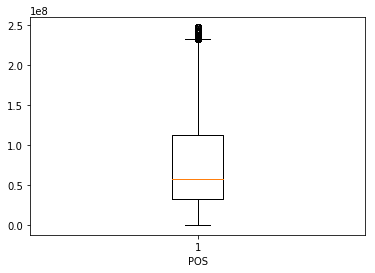

Outlier ratio for AF_ESP is 20.954777 %


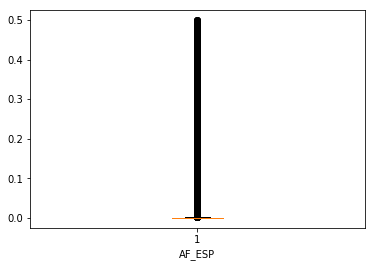

Outlier ratio for AF_EXAC is 19.825735 %


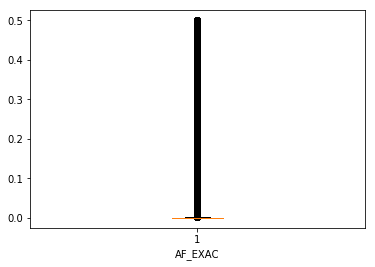

Outlier ratio for AF_TGP is 19.822667 %


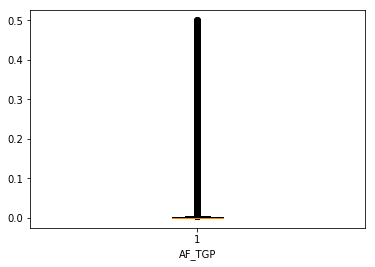

Outlier ratio for LoFtool is 0.000000 %


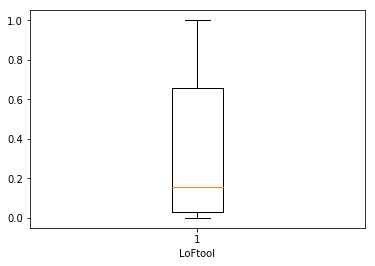

Outlier ratio for CADD_PHRED is 0.000000 %


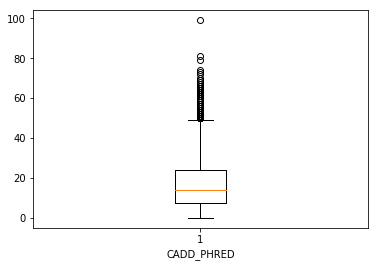

Outlier ratio for CADD_RAW is 0.062895 %


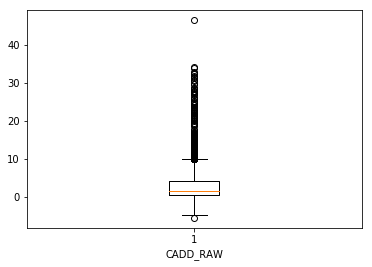

In [22]:
# Check for outliers using IQR method
for attr in ["POS", "AF_ESP", "AF_EXAC", "AF_TGP", "LoFtool", "CADD_PHRED", "CADD_RAW"]:
    wo_outliers = dataMain.outliers_iqr(col=attr, error_margin=0, mode_outliers=True)
    print("Outlier ratio for %s is %f %%" % (attr, wo_outliers.count() / total_rows * 100))
    dataMain.simple_plot("boxplot", attr)
        


# Write Data

In [18]:
# Save to temporary storage
fileref = "cleaned_data.csv"
               
dataMain.dataset.write.option("header", True).mode("overwrite").csv(fileref)

In [23]:
dataMain.dataset.write.mode("overwrite").parquet("cleaned_data_p.parquet")